In [5]:
import numpy as np
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet

import jax
import jax.numpy as jnp
from jax import random, jit
from jax.random import PRNGKey

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import importlib

import sys
import os
path_ = os.path.abspath(os.path.join('..', '00_utils'))
if path_ not in sys.path:
    sys.path.append(path_)
path_ = os.path.abspath(os.path.join('..', '00_models'))
if path_ not in sys.path:
    sys.path.append(path_)

from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data

import nn_jax_diffrax

In [3]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = np.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho, y_ho, y_noisy_ho, true_derivatives_ho = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_ho = jnp.array(jnp.squeeze(y_noisy_ho))
t_ho = jnp.array(jnp.squeeze(t_ho))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_ho, y_test_ho, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

In [6]:
importlib.reload(nn_jax_diffrax)
NeuralODE_JAX = nn_jax_diffrax.NeuralODE

In [12]:
y_pred_results = {}

layer_widths = [2, 64, 64, 2]
learning_rate = 1e-3
rng = random.PRNGKey(42)

node_model = NeuralODE_JAX(layer_widths, time_invariant=True)
state = node_model.create_train_state(rng, learning_rate)

y0 = initial_state

solver_time = 0
mae_train, mae_test = 0, 0
for i in range(10):
    k = int(0.2*N)
    state = node_model.train( state, t_ho[:k] 
                            , y_noisy_ho[:k], y0
                            , num_epochs = 500
                            )
    time_start = time.time()
    k = N
    state = node_model.train( state, t_ho[:k] 
                            , y_noisy_ho[:k], y0
                            , num_epochs = 500
                            )
    time_end = time.time()
    solver_time += time_end - time_start
    
    y_train_pred = node_model.neural_ode(state.params, initial_state, t_ho, state)
    mae_train += np.mean(np.abs(y_ho - y_train_pred))
    
    y_test_pred = node_model.neural_ode(state.params, initial_state, t_test_ho, state)
    mae_test += np.mean(np.abs(y_test_ho - y_test_pred))

Epoch 100, Loss: 4.265145301818848
Epoch 200, Loss: 3.9872727394104004
Epoch 300, Loss: 3.909290313720703
Epoch 400, Loss: 3.841811180114746
Epoch 500, Loss: 3.794768810272217
Epoch 100, Loss: 134.63580322265625
Epoch 200, Loss: 16.765832901000977
Epoch 300, Loss: 16.629993438720703
Epoch 400, Loss: 16.53873062133789
Epoch 500, Loss: 16.60980987548828
Epoch 100, Loss: 3.8087878227233887
Epoch 200, Loss: 3.806931257247925
Epoch 300, Loss: 3.80381178855896
Epoch 400, Loss: 3.8008646965026855
Epoch 500, Loss: 3.798261880874634
Epoch 100, Loss: 16.44367218017578
Epoch 200, Loss: 16.498838424682617
Epoch 300, Loss: 16.355085372924805
Epoch 400, Loss: 16.271100997924805
Epoch 500, Loss: 16.235740661621094
Epoch 100, Loss: 3.8040578365325928
Epoch 200, Loss: 3.8000094890594482
Epoch 300, Loss: 3.7986936569213867
Epoch 400, Loss: 3.7965164184570312
Epoch 500, Loss: 3.7919387817382812
Epoch 100, Loss: 16.223159790039062
Epoch 200, Loss: 16.22165870666504
Epoch 300, Loss: 16.185300827026367
Epoc

In [13]:
print(f"Average time elpased: {solver_time/10:.3f}")
print(f"Average mae_train: {mae_train/10:.3f}")
print(f"Average mae_test: {mae_test/10:.3f}")

Average time elpased: 2.433
Average mae_train: 0.036
Average mae_test: 0.049


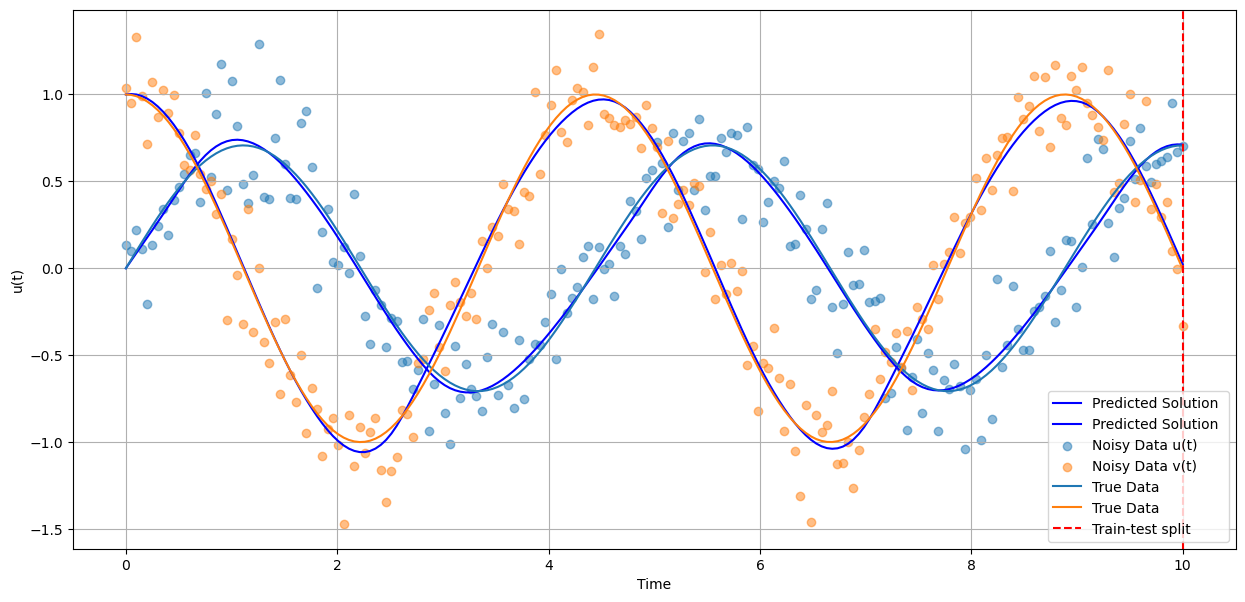

In [14]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_ho, y_train_pred, 'b', label='Predicted Solution ')
#plt.plot(t_test_vdp[N-1:], result['y_test_pred'], 'b', label='Predicted Solution')
#plt.plot(t_test_ho, y_test_ho, 'g--', label='True Solution')
#plt.plot(t_test_ho, y_test_pred, 'g--', label='True Solution')

plt.scatter(t_ho, y_noisy_ho.T[0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_ho, y_noisy_ho.T[1], label='Noisy Data v(t)', alpha = 0.5)
plt.plot(t_ho, y_ho, label='True Data', alpha = 1)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

---
---


In [15]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp, y_vdp, y_noisy_vdp, true_derivatives_vdp = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp = np.array(jnp.squeeze(y_noisy_vdp))
t_vdp = np.array(jnp.squeeze(t_vdp))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_vdp, y_test_vdp, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)


In [18]:
y_pred_results = {}

layer_widths = [3, 64, 64, 2]
learning_rate = 1e-3
rng = PRNGKey(0)

neural_ode_model = NeuralODE_JAX(layer_widths=layer_widths, time_invariant=False)
state = neural_ode_model.create_train_state(rng, learning_rate)

start_timer = time.time()

for k in [int(len(t_vdp)*0.1), len(t_vdp)]:
    trained_state = neural_ode_model.train(state, t_vdp[:k], y_noisy_vdp[:k], initial_state, num_epochs=10000)
end_timer = time.time()
timer = end_timer - start_timer
print(f"Time elapsed: {timer}")

y_train_pred = neural_ode_model.neural_ode(trained_state.params, initial_state, t_vdp, trained_state)

#---------------------------------------------SAVE RESULT---------------------------------------------#
y1 = y_train_pred[-1, :]
# def neural_ode(self, params, y0, t, state):
y_test_pred = neural_ode_model.neural_ode(trained_state.params, y1, t_test_vdp[N-1:], trained_state)
y_pred_results[1] = {"y_train_pred": y_train_pred, "y_test_pred": y_test_pred,
                            "time_elapsed": timer, "y_noisy":y_noisy_vdp}


Epoch 100, Loss: 0.6927184462547302
Epoch 200, Loss: 0.4899003803730011
Epoch 300, Loss: 0.4075161814689636
Epoch 400, Loss: 0.3555062413215637
Epoch 500, Loss: 0.3145555257797241
Epoch 600, Loss: 0.29829543828964233
Epoch 700, Loss: 0.2895709276199341
Epoch 800, Loss: 0.28714117407798767
Epoch 900, Loss: 0.28540268540382385
Epoch 1000, Loss: 0.28183403611183167
Epoch 1100, Loss: 0.2804451286792755
Epoch 1200, Loss: 0.28076499700546265
Epoch 1300, Loss: 0.2963677644729614
Epoch 1400, Loss: 0.2800556719303131
Epoch 1500, Loss: 0.27987101674079895
Epoch 1600, Loss: 0.27664539217948914
Epoch 1700, Loss: 0.3835362493991852
Epoch 1800, Loss: 0.2822287976741791
Epoch 1900, Loss: 0.28200945258140564
Epoch 2000, Loss: 0.28014862537384033
Epoch 2100, Loss: 0.28627872467041016
Epoch 2200, Loss: 0.28270891308784485
Epoch 2300, Loss: 0.28145384788513184
Epoch 2400, Loss: 0.3227316439151764
Epoch 2500, Loss: 0.2832930088043213
Epoch 2600, Loss: 0.27692198753356934
Epoch 2700, Loss: 0.28679856657981

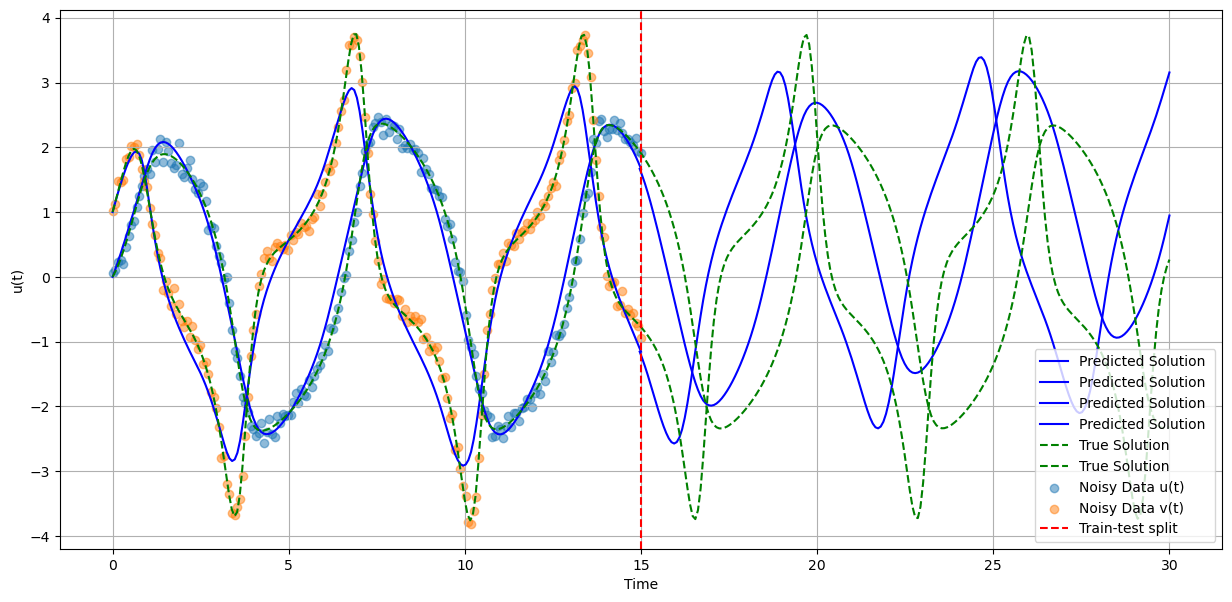

In [19]:
result = y_pred_results[1]

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_vdp, result['y_train_pred'], 'b', label='Predicted Solution ')
plt.plot(t_test_vdp[N-1:], result['y_test_pred'], 'b', label='Predicted Solution')
plt.plot(t_test_vdp, y_test_vdp, 'g--', label='True Solution')

plt.scatter(t_vdp, y_noisy_vdp.T[0], label='Noisy Data u(t)', alpha = 0.5)
plt.scatter(t_vdp, y_noisy_vdp.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=15, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

### Passing Extra Arguments to the ODE Solver